# **Profile-based Retrieval**



In [ ]:
!pip install requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
HINT: You are attempting to install a package literally named "requirements.txt" (which cannot exist). Consider using the '-r' flag to install the packages listed in requirements.txt
ERROR: No matching distribution found for requirements.txt


In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.datasets import fetch_20newsgroups
import string as st
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. We will choose a subset of these 20 groups for the later use in our toy implementation.

In [ ]:
data_train = fetch_20newsgroups(subset='train')
target_names = fetch_20newsgroups().target_names
target_names


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
def twenty_newsgroup_to_csv(option):
    newsgroups_train = fetch_20newsgroups(subset=option, remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    
    out = pd.merge(df, targets, left_on='target', right_index=True)
    if option=='train':
      out.to_csv('20_newsgroup.csv')
    else:
      out.to_csv('20_newsgroup_validation.csv')
    
twenty_newsgroup_to_csv('train')

In [ ]:
df = pd.read_csv('20_newsgroup.csv')
df.columns = ['id','text','target','title']
df = df.drop('id',axis=1)
df

,text,target,title
0,I was wondering if anyone out there could enli...,7,rec.autos
1,I recently posted an article asking what kind ...,7,rec.autos
2,\nIt depends on your priorities. A lot of peo...,7,rec.autos
3,an excellent automatic can be found in the sub...,7,rec.autos
4,: Ford and his automobile. I need information...,7,rec.autos
...,...,...,...
11309,Secrecy in Clipper Chip\n\nThe serial number o...,11,sci.crypt
11310,Hi !\n\nI am interested in the source of FEAL ...,11,sci.crypt
11311,"The actual algorithm is classified, however, t...",11,sci.crypt
11312,\n\tThis appears to be generic calling upon th...,11,sci.crypt


Our topics of interest: `politics`, `religion`, `medicine`, `space`, `electronics` and `baseball`.

In [ ]:
selection= ['talk.politics.misc','talk.religion.misc','sci.med','sci.space','sci.electronics','rec.sport.baseball']

In [ ]:
df=df[df['title'].isin(selection)]
df

,text,target,title
1756,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space
1757,"\n {Description of ""External Tank"" option fo...",14,sci.space
1758,"Pat sez;\n\nYeah, but a windscreen cut down mo...",14,sci.space
1759,Archive-name: space/new_probes\nLast-modified:...,14,sci.space
1760,\nWhere does the shadow come from? There's no...,14,sci.space
...,...,...,...
10714,\n\nWhere did you hear this? I seem to have m...,18,talk.politics.misc
10715,"# ## Face it, Clayton, he was not found guilty...",18,talk.politics.misc
10716,"\nAgain, Mr. Frank has come to the rescue with...",18,talk.politics.misc
10717,\n\tIt seems radio reports were overly optimis...,18,talk.politics.misc


## **Exploratory Data Analysis**

There are some missing values (a total of 75), given the size of the data we may simply delete the pertaining rows.

In [ ]:
print(df.isna().sum())
df=df.dropna()

text      75
target     0
title      0
dtype: int64


There are the same number of records for all the categories, give or take. The less populated category by far is religion.

In [ ]:
print(f"\n{df['title'].value_counts()}\n")



sci.med               583
rec.sport.baseball    581
sci.space             580
sci.electronics       577
talk.politics.misc    458
talk.religion.misc    363
Name: title, dtype: int64



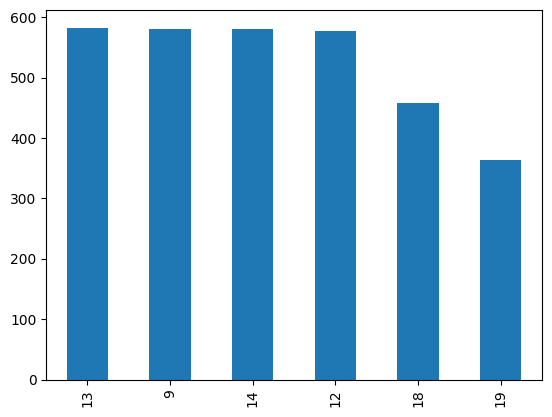

In [ ]:
df['target'].value_counts().plot(kind='bar')
plt.show()

Then, we use a world cloud generator to visualize the most popular choices of words when talking about these topics. It's clear which words take the cake: *one*, *year* and *people*.

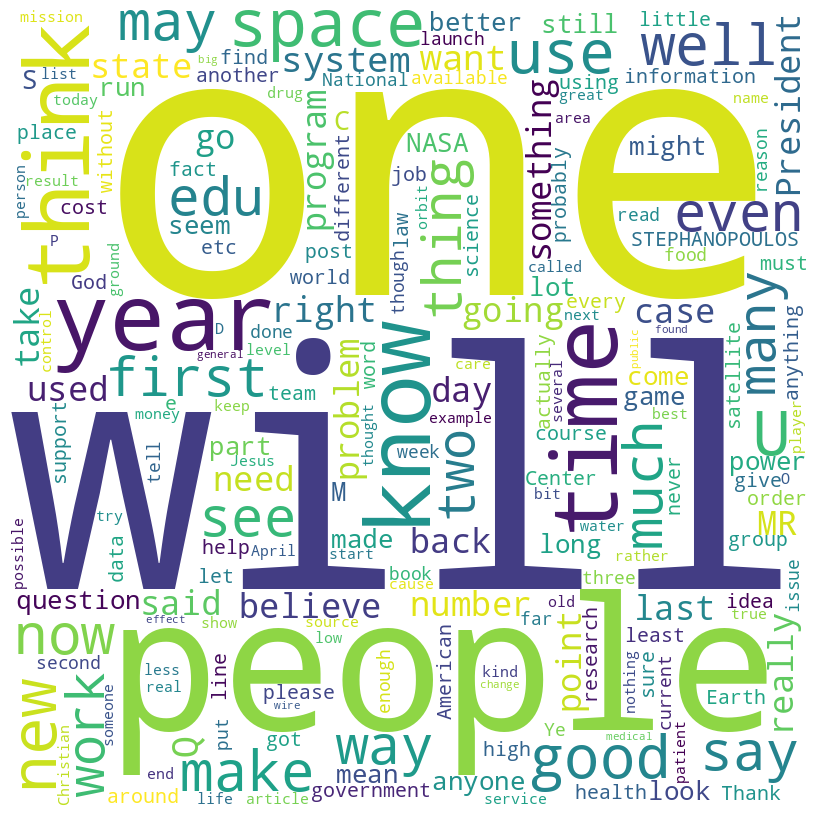

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10,collocations=False).generate(' '.join(df['text']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(df['text'])
terms = vectorizer.get_feature_names_out()

#plt.imshow(tfidf.todense(), interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
#plt.xticks(range(len(terms)), terms, rotation=90)
#plt.gca().invert_yaxis()
#plt.show()

We can also perform a sentiment analysis for all the pieces of text. Overall, most texts are neutral or even a mix of positive and negative nuances, which is to  be expected.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-61-7017d76f4f00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['text'].apply(get_sentiment)


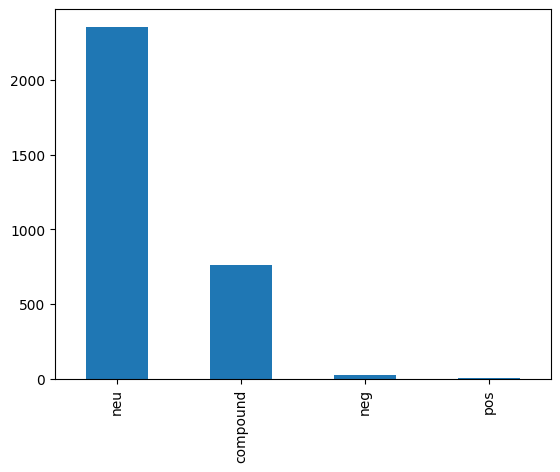

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return max(sentiment, key=sentiment.get)

df['sentiment'] = df['text'].apply(get_sentiment)
df['sentiment'].value_counts().plot(kind='bar')
plt.show()


We can also use Latent Dirichlet Allocation (LDA), which is a topic modelling technique that can classify text in a document to a particular topic. In this regard, we will choose to group all texts from 6 topics in only three topics, and see the most relevant words for the classification in each topic.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(tfidf)

for i, topic in enumerate(lda.components_):
    print(f'Topic {i}:')
    print([terms[index] for index in topic.argsort()[-10:]])


Topic 0:
['space', 'time', 'good', 'does', 'think', 'people', 'know', 'just', 'like', 'don']
Topic 1:
['ampere', 'ye', 'fpu', 'baden', '2600', 'gehrels', 'hook', 'yo', 'sig', 'dial']
Topic 2:
['deane', 'panicking', 'b30', 'ingr', 'catbyte', 'dtmedin', '205', 'ground', 'centaur', 'pin']


## **Pre-processing**

As in any natural language process, we need to do some preprocessing of the data: 
- remove punctuations in our string documents (`text` column)
- tokenize the strings 
- remove small tokens
- filter out stop words
- stemming and lemmatizating

In [ ]:
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\t', ' ').replace('-',' ')  # remove newline and tab characters
    text= "".join([ch for ch in text if ch not in st.punctuation])
    tokens = word_tokenize(text.lower())  # tokenize and lowercase
    #tokens = [t for t in tokens if t not in st.punctuation]  # remove punctuation
    tokens = [t for t in tokens if t not in nltk.corpus.stopwords.words('english') and len(t) > 3]  # remove stop words and short words
    stemmer = PorterStemmer()  # apply stemming
    tokens = [stemmer.stem(t) for t in tokens]
    lemmatizer = WordNetLemmatizer()  # apply lemmatization
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

print('This is an e3xample old-text! for demostration# purposes.')
prueba = preprocess_text('This is an e3xample old-text! for demostration# purposes.')
print(prueba)

This is an e3xample old-text! for demostration# purposes.
e3xampl text demostr purpos


In [ ]:
df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x))

<ipython-input-64-da71acfcf413>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x))


In [ ]:
df

,text,target,title,sentiment,clean_text
1756,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space,neu,articl c5owcbn3pworldstdcom tombakerworldstdco...
1757,"\n {Description of ""External Tank"" option fo...",14,sci.space,compound,descript extern tank option redesign delet let...
1758,"Pat sez;\n\nYeah, but a windscreen cut down mo...",14,sci.space,neu,yeah windscreen canopi end complet cours envir...
1759,Archive-name: space/new_probes\nLast-modified:...,14,sci.space,compound,archiv name spacenewprob last modifi date 9304...
1760,\nWhere does the shadow come from? There's no...,14,sci.space,neu,shadow come there noth close enough block sunl...
...,...,...,...,...,...
10714,\n\nWhere did you hear this? I seem to have m...,18,talk.politics.misc,neu,hear seem miss burn regardless verdict count b...
10715,"# ## Face it, Clayton, he was not found guilty...",18,talk.politics.misc,neu,face clayton found guilti gay sometim make con...
10716,"\nAgain, Mr. Frank has come to the rescue with...",18,talk.politics.misc,neu,frank come rescu cool head reason charg victim...
10717,\n\tIt seems radio reports were overly optimis...,18,talk.politics.misc,neu,seem radio report overli optimist clinton want...


We can see that the word cloud representation has shifted after the preprocessing, the weight distribution is not as asymmetrical: *year*, *peopl*, *time*, *think*, *dont*, *are*, *know*, *space* and *work* are all now quite significant in the analysis and hold similar weights.






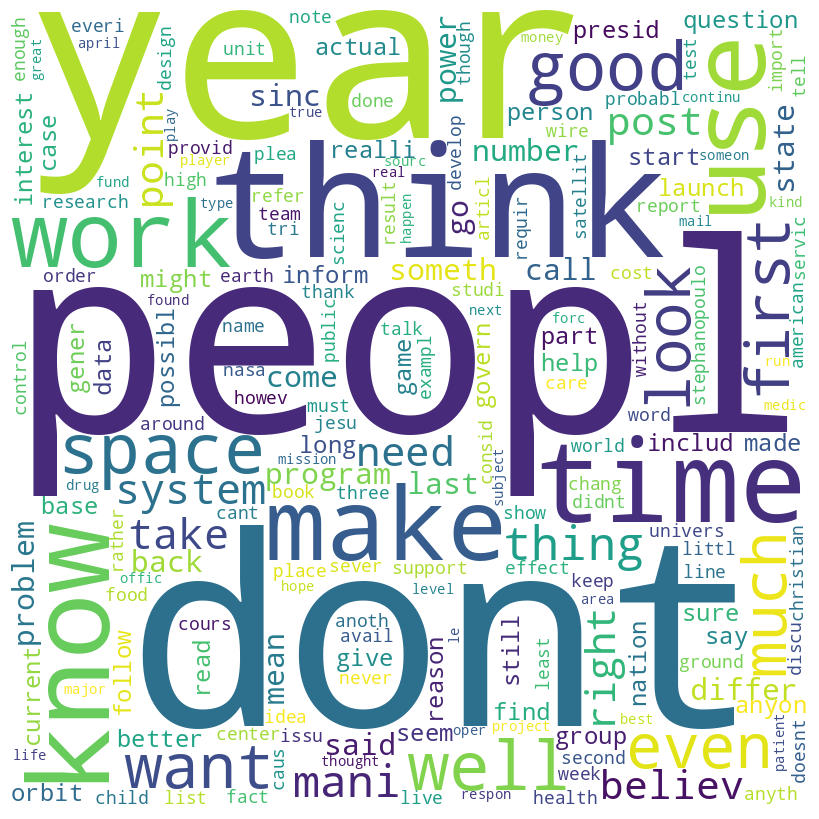

In [ ]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10,collocations=False).generate(' '.join(df['clean_text']))
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## **Model implementation**

We will use our column `clean_text` to calculate the TF-IDF numerical vectors of the tokenized inputs.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['target'], test_size=0.3, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
import time

We define the different models we may use for our toy implementation: logistic regression, MLP, multinomial Naive-Bayes, SVM, decision tree and random forest. All able to handle a multiclass classification problem.

In [ ]:
def tt_logisticRegression(X_train,X_test,y_train,y_test):
    print("=" * 80)
    print("Logistic Regression")
    print("=" * 80)
    # Training the model
    print("Training:")
    t0 = time.time()
    param_grid = {
    'C': [0.1, 1, 5, 10],}

    print("Hypertuning the model...")
    grid_search = GridSearchCV(LogisticRegression(solver='saga',multi_class='multinomial',penalty = 'l2'), param_grid=param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f"Train time: {train_time:.2f}s")

    # Make predictions on test data
    print("Testing:")
    t0 = time.time()
    y_pred = grid_search.predict(X_test)
    test_time = time.time() - t0
    print(f"Test time: {test_time:.2f}s")

    # Evaluating the model
    print("\n")
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
    print("-" * 80)

    return grid_search
    

In [ ]:
def tt_MLP(X_train,X_test,y_train,y_test):
    print("=" * 80)
    print("Multi-layer Perceptron")
    print("=" * 80)
    # Training the model
    print("Training:")
    t0 = time.time()
    param_grid = {}
    #print("Hypertuning the model...")
    grid_search = GridSearchCV(MLPClassifier(activation='relu',solver='adam'), param_grid=param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f"Train time: {train_time:.2f}s")

    # Make predictions on test data
    print("Testing:")
    t0 = time.time()
    y_pred = grid_search.predict(X_test)
    test_time = time.time() - t0
    print(f"Test time: {test_time:.2f}s")

    # Evaluating the model
    print("\n")
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
    print("-" * 80)

    return grid_search
    

In [ ]:
def tt_multinomialNB(X_train,X_test,y_train,y_test):
    print("=" * 80)
    print("Multinomial Naive-Bayes")
    print("=" * 80)
    # Training the model
    print("Training:")
    t0 = time.time()
    param_grid = {'alpha': [0.1, 1.0, 10.0]}
    print("Hypertuning the model...")
    grid_search = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f"Train time: {train_time:.2f}s")

    # Make predictions on test data
    print("Testing:")
    t0 = time.time()
    y_pred = grid_search.predict(X_test)
    test_time = time.time() - t0
    print(f"Test time: {test_time:.2f}s")

    # Evaluating the model
    print("\n")
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
    print("-" * 80)

    return grid_search
    

In [ ]:
def tt_SVC(X_train,X_test,y_train,y_test):
    print("=" * 80)
    print("Support Vector Machine")
    print("=" * 80)
    # Training the model
    print("Training:")
    t0 = time.time()
    param_grid = {'C': [0.1, 5,1.0, 10.0]}
    print("Hypertuning the model...")
    grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f"Train time: {train_time:.2f}s")

    # Make predictions on test data
    print("Testing:")
    t0 = time.time()
    y_pred = grid_search.predict(X_test)
    test_time = time.time() - t0
    print(f"Test time: {test_time:.2f}s")

    # Evaluating the model
    print("\n")
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
    print("-" * 80)

    return grid_search
    

In [ ]:
def tt_decisionTree(X_train,X_test,y_train,y_test):
    print("=" * 80)
    print("Decision Tree classifier")
    print("=" * 80)
    # Training the model
    print("Training:")
    t0 = time.time()
    param_grid = {'max_depth': [1, 5, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
    print("Hypertuning the model...")
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f"Train time: {train_time:.2f}s")

    # Make predictions on test data
    print("Testing:")
    t0 = time.time()
    y_pred = grid_search.predict(X_test)
    test_time = time.time() - t0
    print(f"Test time: {test_time:.2f}s")

    # Evaluating the model
    print("\n")
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
    print("-" * 80)

    return grid_search
    

In [ ]:
def tt_randomForest(X_train,X_test,y_train,y_test):
    print("=" * 80)
    print("Random Forest classifier")
    print("=" * 80)
    # Training the model
    print("Training:")
    t0 = time.time()
    param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],}

    print("Hypertuning the model...")
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
    grid_search.fit(X_train_tfidf, y_train)
    train_time = time.time() - t0
    print(f"Train time: {train_time:.2f}s")

    # Make predictions on test data
    print("Testing:")
    t0 = time.time()
    y_pred = grid_search.predict(X_test)
    test_time = time.time() - t0
    print(f"Test time: {test_time:.2f}s")

    # Evaluating the model
    print("\n")
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))
    print("-" * 80)
    
    return grid_search
    

In [ ]:
tt_logisticRegression(X_train_tfidf, X_test_tfidf, y_train,y_test)

Logistic Regression
Training:
Hypertuning the model...
Train time: 5.18s
Testing:
Test time: 0.00s


              precision    recall  f1-score   support

           9       0.82      0.94      0.88       163
          12       0.82      0.90      0.86       156
          13       0.91      0.88      0.90       172
          14       0.90      0.83      0.86       198
          18       0.86      0.88      0.87       141
          19       0.86      0.67      0.76       113

    accuracy                           0.86       943
   macro avg       0.86      0.85      0.85       943
weighted avg       0.86      0.86      0.86       943

Confusion Matrix:
 [[154   2   0   3   1   3]
 [  9 141   1   3   1   1]
 [  6   7 152   5   2   0]
 [  4  12   5 165   7   5]
 [  4   4   3   3 124   3]
 [ 11   5   6   5  10  76]]
--------------------------------------------------------------------------------


GridSearchCV(cv=5,
             estimator=LogisticRegression(multi_class='multinomial',
                                          solver='saga'),
             param_grid={'C': [0.1, 1, 5, 10]})

In [ ]:
tt_MLP(X_train_tfidf, X_test_tfidf, y_train,y_test)

Multi-layer Perceptron
Training:
Train time: 310.88s
Testing:
Test time: 0.01s


              precision    recall  f1-score   support

           9       0.83      0.96      0.89       163
          12       0.87      0.87      0.87       156
          13       0.89      0.92      0.90       172
          14       0.89      0.84      0.86       198
          18       0.85      0.86      0.86       141
          19       0.91      0.75      0.83       113

    accuracy                           0.87       943
   macro avg       0.87      0.86      0.87       943
weighted avg       0.87      0.87      0.87       943

Confusion Matrix:
 [[156   2   0   2   1   2]
 [  8 135   3   9   1   0]
 [  6   3 158   3   2   0]
 [  6   9   5 166   9   3]
 [  5   2   6   4 121   3]
 [  7   4   6   3   8  85]]
--------------------------------------------------------------------------------


GridSearchCV(cv=5, estimator=MLPClassifier(), param_grid={})

In [ ]:
tt_multinomialNB(X_train_tfidf, X_test_tfidf, y_train,y_test)

Multinomial Naive-Bayes
Training:
Hypertuning the model...
Train time: 0.10s
Testing:
Test time: 0.00s


              precision    recall  f1-score   support

           9       0.91      0.94      0.92       163
          12       0.84      0.91      0.87       156
          13       0.85      0.92      0.89       172
          14       0.90      0.85      0.88       198
          18       0.85      0.87      0.86       141
          19       0.94      0.73      0.83       113

    accuracy                           0.88       943
   macro avg       0.88      0.87      0.87       943
weighted avg       0.88      0.88      0.88       943

Confusion Matrix:
 [[153   6   2   0   1   1]
 [  2 142   0   9   2   1]
 [  2   5 158   5   2   0]
 [  5  10   7 169   5   2]
 [  3   2  10   2 123   1]
 [  4   4   8   2  12  83]]
--------------------------------------------------------------------------------


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 1.0, 10.0]})

In [ ]:
tt_SVC(X_train_tfidf, X_test_tfidf, y_train,y_test)

Support Vector Machine
Training:
Hypertuning the model...
Train time: 53.74s
Testing:
Test time: 0.83s


              precision    recall  f1-score   support

           9       0.84      0.94      0.88       163
          12       0.83      0.92      0.87       156
          13       0.87      0.91      0.89       172
          14       0.88      0.85      0.87       198
          18       0.87      0.89      0.88       141
          19       0.96      0.64      0.77       113

    accuracy                           0.87       943
   macro avg       0.88      0.86      0.86       943
weighted avg       0.87      0.87      0.86       943

Confusion Matrix:
 [[153   3   2   3   1   1]
 [  8 143   1   3   1   0]
 [  4   7 156   3   2   0]
 [  4  12   7 168   5   2]
 [  4   3   3   6 125   0]
 [ 10   5  10   7   9  72]]
--------------------------------------------------------------------------------


GridSearchCV(cv=5, estimator=SVC(), param_grid={'C': [0.1, 5, 1.0, 10.0]})

In [ ]:
tt_decisionTree(X_train_tfidf, X_test_tfidf, y_train,y_test)

Decision Tree classifier
Training:
Hypertuning the model...
Train time: 12.57s
Testing:
Test time: 0.00s


              precision    recall  f1-score   support

           9       0.93      0.38      0.54       163
          12       0.22      0.96      0.36       156
          13       0.90      0.26      0.40       172
          14       0.89      0.37      0.52       198
          18       0.67      0.25      0.36       141
          19       0.86      0.21      0.34       113

    accuracy                           0.41       943
   macro avg       0.74      0.40      0.42       943
weighted avg       0.75      0.41      0.43       943

Confusion Matrix:
 [[ 62 100   1   0   0   0]
 [  2 149   1   3   0   1]
 [  0 121  44   3   4   0]
 [  0 114   2  73   7   2]
 [  2  99   1   3  35   1]
 [  1  82   0   0   6  24]]
--------------------------------------------------------------------------------


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
tt_randomForest(X_train_tfidf, X_test_tfidf, y_train,y_test)

Random Forest classifier
Training:
Hypertuning the model...
Train time: 193.55s
Testing:
Test time: 0.07s


              precision    recall  f1-score   support

           9       0.78      0.82      0.80       163
          12       0.42      0.91      0.58       156
          13       0.85      0.77      0.80       172
          14       0.93      0.65      0.76       198
          18       0.81      0.55      0.65       141
          19       0.96      0.38      0.54       113

    accuracy                           0.70       943
   macro avg       0.79      0.68      0.69       943
weighted avg       0.79      0.70      0.70       943

Confusion Matrix:
 [[134  26   2   1   0   0]
 [  7 142   2   5   0   0]
 [  3  35 132   1   1   0]
 [  6  53   3 128   7   1]
 [ 14  39   8   2  77   1]
 [  8  42   9   1  10  43]]
--------------------------------------------------------------------------------


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

All models pretty much offer the same performance, although the multinomial Naive Bayes has slightly better metrics. This will be our chosen model for the toy profile-based IRS.

## **Toy profile-based IRS**

First, we create our random set of users with random chosen interests. The encode will be simple, each user is encoded by a list of the corresponding topic identification numbers.

In [ ]:
import random

In [ ]:
indexes=[]
for theme in selection:
  indexes.append(df.loc[df['title'] == theme, 'target'].iloc[0])

mapping=dict(zip(indexes,selection))
mapping

{18: 'talk.politics.misc',
 19: 'talk.religion.misc',
 13: 'sci.med',
 14: 'sci.space',
 12: 'sci.electronics',
 9: 'rec.sport.baseball'}

In [ ]:
toy_users={}
for i in range(1,6):
  n_topic = random.randint(1, 2)
  n_interests = random.sample(list(mapping.keys()),n_topic)
  toy_users[i] = n_interests
  
toy_users

{1: [14], 2: [14], 3: [19, 14], 4: [14], 5: [9]}

For example, we can choose a news article about space: [*Spacesuit for return to the Moon unveiled (BBC news)*](https://www.bbc.com/news/science-environment-649657679). With this, we can try to classify a piece of text from the article and assign it to the users that may be interested in said topic.

In [ ]:
text1 = "The key requirement of a spacesuit is to provide oxygen at the right pressure to the astronauts which allow them to survive in the near-vacuum of space. This aspect requires careful design, as failure would see an astronaut's lungs rapidly expand causing death. 'We have a lot of tough requirements on this suit,' said Lara Kearney, manager of Nasa's spacesuit and rovers team, at today's demonstration of the new design."
text1_clean = preprocess_text(text1)
single_entry = tfidf_vectorizer.transform([text1_clean])

The previously trained multinomial Naive Bayes:

In [ ]:
model=tt_multinomialNB(X_train_tfidf, X_test_tfidf, y_train,y_test)
print(model)

Multinomial Naive-Bayes
Training:
Hypertuning the model...
Train time: 0.10s
Testing:
Test time: 0.00s


              precision    recall  f1-score   support

           9       0.91      0.94      0.92       163
          12       0.84      0.91      0.87       156
          13       0.85      0.92      0.89       172
          14       0.90      0.85      0.88       198
          18       0.85      0.87      0.86       141
          19       0.94      0.73      0.83       113

    accuracy                           0.88       943
   macro avg       0.88      0.87      0.87       943
weighted avg       0.88      0.88      0.88       943

Confusion Matrix:
 [[153   6   2   0   1   1]
 [  2 142   0   9   2   1]
 [  2   5 158   5   2   0]
 [  5  10   7 169   5   2]
 [  3   2  10   2 123   1]
 [  4   4   8   2  12  83]]
--------------------------------------------------------------------------------
GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 1.0

In [ ]:
def app(preds):
  for pred in preds:
    print("="*80)
    print(f"The predicted category of the toy text query is {mapping[pred].upper()}")
    print("="*80)
    print("="*80)


    users=[]
    for key,values in toy_users.items():
      [print(f"The USER {key} is interested in {mapping[value].upper()}.") for value in values if value == pred]
      if pred in values:
        users.append(key)
      print("-"*80)
    
    if len(users)==0:
      print("No users are interested in that topic.")
    print("="*80)

In [ ]:
pred=list(model.predict(single_entry))

app(pred)

The predicted category of the toy text query is SCI.SPACE
The USER 1 is interested in SCI.SPACE.
--------------------------------------------------------------------------------
The USER 2 is interested in SCI.SPACE.
--------------------------------------------------------------------------------
The USER 3 is interested in SCI.SPACE.
--------------------------------------------------------------------------------
The USER 4 is interested in SCI.SPACE.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


We load our validation set from 20newsgroup.

In [ ]:
twenty_newsgroup_to_csv('test')

In [ ]:
df_validation = pd.read_csv('20_newsgroup_validation.csv')
df_validation.columns = ['id','text','target','title']
df_validation = df_validation.drop('id',axis=1)
df_validation

,text,target,title
0,I am a little confused on all of the models of...,7,rec.autos
1,I have a 90 Eagle Talon and I wanted a pair of...,7,rec.autos
2,"Hi,\nI need your help with a problem I have wi...",7,rec.autos
3,\nThey changed the lights and slope of the hoo...,7,rec.autos
4,I am thinking of buying a used Audi 90 Auto.\n...,7,rec.autos
...,...,...,...
7527,\nI think it's because the lead gets coated wi...,12,sci.electronics
7528,"\n\nWith regards to what you wrote, how does ...",12,sci.electronics
7529,\nWhy can't he record it legally? It may not ...,12,sci.electronics
7530,\n\n\nIt sorta depends on what you drive. I re...,12,sci.electronics


We select only the rows belonging to our topics of interest:

In [ ]:
df_validation=df_validation[df_validation['title'].isin(selection)]
df_validation=df_validation.dropna()
df_validation

,text,target,title
1486,\nI've just spent two solid months arguing tha...,19,talk.religion.misc
1487,-- \nDouglas C. Meier\t\t| You can't play Ele...,19,talk.religion.misc
1488,"\nNo, which is why I want an investigation. \...",19,talk.religion.misc
1489,\n\tI'm not sure that you can distinguish betw...,19,talk.religion.misc
1490,(Anthony \n\nIf she doesn't welcome the excruc...,19,talk.religion.misc
...,...,...,...
7527,\nI think it's because the lead gets coated wi...,12,sci.electronics
7528,"\n\nWith regards to what you wrote, how does ...",12,sci.electronics
7529,\nWhy can't he record it legally? It may not ...,12,sci.electronics
7530,\n\n\nIt sorta depends on what you drive. I re...,12,sci.electronics


In [ ]:
df_validation['clean_text']=df_validation['text'].apply(lambda x: preprocess_text(x))

In [ ]:
df_validation['clean_text'][0:21]

1486    spent solid month argu thing object moral syst...
1487    dougla meier cant play electro magnet golf nor...
1488    want investig ever said obviou defend follow g...
1489    sure distinguish myth legend neatli myth singl...
1490    anthoni doesnt welcom excruci pain labor selfi...
1491    possibl parallel stem tend sourc anyway dont t...
1492    check news today author also found state autom...
1493    sure teach accur perceiv realiti tricki busi t...
1494    point suppos open mind mean believ anyth true ...
1495    mayb without somebodi time doesnt good humph d...
1496    that right everyon even infant speak even litt...
1497    look alllth pretti puddl jimmi crack koan dont...
1498    1993apr2421484310940midwayuchicagoedu eeb1quad...
1499                                   stuff mithra delet
1500    theist truli object imparti question truth scr...
1501                                    apolog pay attent
1502                                                     
1503    brian 

In [ ]:
X_validation = tfidf_vectorizer.transform(df_validation['clean_text'][0:21])

In [ ]:
preds=model.predict(X_validation)

In [ ]:
app(preds)

The predicted category of the toy text query is TALK.RELIGION.MISC
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
The USER 3 is interested in TALK.RELIGION.MISC.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
The predicted category of the toy text query is REC.SPORT.BASEBALL
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
The USER 5 is interested in REC.SPORT.BASEBALL.
-----------------------------------------